<a href="https://colab.research.google.com/github/BritVandy/Zoo-predicting-predators/blob/main/Zoo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install necessary packages in Google Colab

!pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip
!pip install category_encoders==2.*
!pip install eli5
!pip install pdpbox
!pip install shap

In [ ]:
# Import necessary packages

from google.colab import files
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from pandas_profiling import ProfileReport
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_curve
import seaborn as sns
import category_encoders as ce
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint, uniform
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import eli5
from eli5.sklearn import PermutationImportance
import matplotlib.pyplot as plt
from pdpbox.pdp import pdp_isolate, pdp_plot
from pdpbox.pdp import pdp_interact, pdp_interact_plot
from pdpbox import pdp

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
# This dataset is from the UCI Machine Learning Repository http://archive.ics.uci.edu/ml/datasets/Zoo

uploaded = files.upload()

Saving zoo.data to zoo.data


In [ ]:
# Read the csv into a dataframe

df = pd.read_csv('zoo.data')

In [ ]:
# Name the columns

df.columns = ['name', 'hair', 'feathers', 'eggs', 'milk', 'airborne', 'aquatic', 'predator', 'toothed', 'backbone', 'breathes', 'venomous', 'fins', 'legs', 'tail', 'domestic', 'catsize', 'type']

In [ ]:
# Taking a look at the head of the dataframe to see what we're working with

df.head()

,name,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,type
0,antelope,1,0,0,1,0,0,0,1,1,1,0,0,4,1,0,1,1
1,bass,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,0,4
2,bear,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
3,boar,1,0,0,1,0,0,1,1,1,1,0,0,4,1,0,1,1
4,buffalo,1,0,0,1,0,0,0,1,1,1,0,0,4,1,0,1,1


In [ ]:
# Pandas profiling gives a pretty good visual of the dataset

profile = ProfileReport(df, minimal=True).to_notebook_iframe()

profile

In [ ]:
# Split the data into train, val, and test subsets

train, test = train_test_split(df, train_size = 0.90, test_size = 0.10, random_state = 42)
train, val = train_test_split(train, train_size = 0.80, test_size = 0.20, random_state = 42)

In [ ]:
# Split data into their X and ys

target = 'predator'
features = train.drop(columns = [target]).columns.tolist()

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

In [ ]:
# Check the distribution on the target

y_train.value_counts(normalize=True)

1    0.527778
0    0.472222
Name: predator, dtype: float64

In [ ]:
# Define a wrangle funtion to edit the data

def wrangle(X):
  # drop leaky columns
  cols_to_drop = ['type']
  X = X.drop(columns=cols_to_drop)
  # set index
  X = X.set_index('name')
  return X

In [ ]:
# Baseline accuracy

majority_class = y_train.mode()[0]
y_pred_baseline = [majority_class] * len(y_train)

accuracy_score(y_train, y_pred_baseline)

0.5277777777777778

In [ ]:
# Logistic regression model

log_model = make_pipeline(
    FunctionTransformer(wrangle, validate = False),
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='mean'), 
    LogisticRegressionCV(multi_class='auto', solver='lbfgs', n_jobs=-1)
)

log_model.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('functiontransformer',
                 FunctionTransformer(accept_sparse=False, check_inverse=True,
                                     func=<function wrangle at 0x7fda79ceee60>,
                                     inv_kw_args=None, inverse_func=None,
                                     kw_args=None, validate=False)),
                ('ordinalencoder',
                 OrdinalEncoder(cols=[], drop_invariant=False,
                                handle_missing='value', handle_unknown='value',
                                mapping=[], return_df=True, ve...
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='mean',
                               verbose=0)),
                ('logisticregressioncv',
                 LogisticRegressionCV(Cs=10, class_weight=None, cv=None,
                                      dual=False, fit_intercept=True,
                 

In [ ]:
# Find out the accuracy of the model
# Beat the baseline, but not by very much

print('Accuracy:', log_model.score(X_val, y_val))

Accuracy: 0.5555555555555556


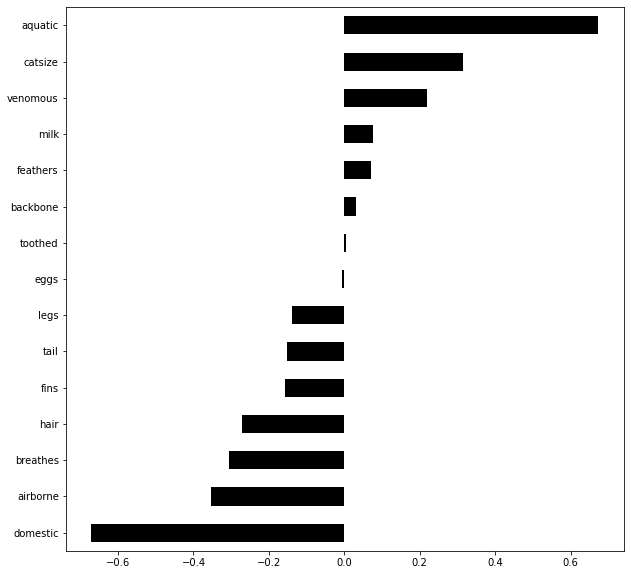

In [ ]:
# Plot the coefficients for the log model
# This tells us how important each feature is to the logistic regression model

model = log_model.named_steps['logisticregressioncv']
transformed = log_model.named_steps['functiontransformer']
transformed_columns = transformed.transform(X_val).columns
coefficients = pd.Series(model.coef_[0], transformed_columns)
plt.figure(figsize=(10, 10))
coefficients.sort_values().plot.barh(color = 'black')

In [ ]:
# RandomizedSearchCV checks for the best possible parameters for a model within
# parameters that you set 

pipeline = make_pipeline(
    FunctionTransformer(wrangle, validate = False), 
    ce.OrdinalEncoder(), 
    SimpleImputer(), 
    RandomForestClassifier())

param_distributions = {'simpleimputer__strategy':['mean', 'median', 'most_frequent'], 
                       'randomforestclassifier__random_state': randint(0, 100), 
                       'randomforestclassifier__max_depth': randint(0, 50), 
                       'randomforestclassifier__n_estimators': randint(0, 75), 
                       'randomforestclassifier__max_features': uniform(0, 1)
}

search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_distributions, 
    n_iter = 15, 
    cv= 10, 
    scoring = 'accuracy', 
    verbose = 10, 
    return_train_score = True, 
    n_jobs = -1
)

search.fit(X_train, y_train);

Fitting 10 folds for each of 15 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1873s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 110 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    9.6s finished


In [ ]:
# Print out the best parameters and best score of the RandomizedSearchCV 
# to be able to apply to other models

print(search.best_params_)
print(-search.best_score_)

{'randomforestclassifier__max_depth': 28, 'randomforestclassifier__max_features': 0.8442893689364672, 'randomforestclassifier__n_estimators': 26, 'randomforestclassifier__random_state': 25, 'simpleimputer__strategy': 'mean'}
-0.5982142857142857


In [ ]:
# Fit a classification model with a RandomForest

model_one = make_pipeline(
    FunctionTransformer(wrangle, validate = False),
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='mean'),  
    RandomForestClassifier(random_state = 42, n_estimators= 15, n_jobs=-1, max_depth= 20, max_features=0.35) 
)

model_one.fit(X_train, y_train)
print('Train accuracy:', model_one.score(X_train, y_train))
print('Val accuracy:', model_one.score(X_val, y_val))

Train accuracy: 0.8055555555555556
Val accuracy: 0.7777777777777778


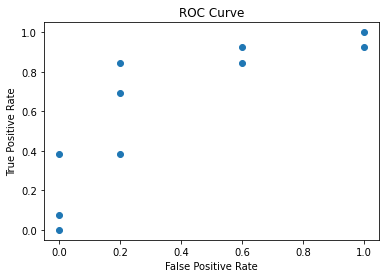

In [ ]:
# ROC curve of the random forest classifier model

y_pred_proba = model_one.predict_proba(X_val)[:,1]

fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)

plt.scatter(fpr, tpr)
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate');

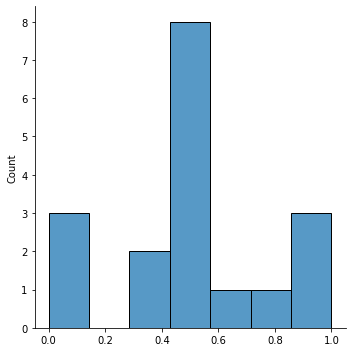

In [ ]:
# Distribution plot of the random forest classifier model

sns.displot(y_pred_proba);

In [ ]:
# Fit a model with XG Boost

model_two = make_pipeline(
    FunctionTransformer(wrangle, validate = False),
    ce.OrdinalEncoder(), 
    XGBClassifier(random_state = 0, n_estimators= 5, n_jobs=-1, max_depth= 7, max_features=0.15)
)

model_two.fit(X_train, y_train)

y_pred_model_two = model_two.predict(X_val)
print('Validation Score: ', accuracy_score(y_val, y_pred_model_two))

Validation Score:  0.6111111111111112


In [ ]:
# Fit a model for permuting

transformers = make_pipeline(
    FunctionTransformer(wrangle, validate = False),
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='most_frequent')
)

X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.transform(X_val)

model_three = RandomForestClassifier(random_state = 42, n_estimators= 15, n_jobs=-1, max_depth= 20, max_features=0.35)
model_three.fit(X_train_transformed, y_train)

permuter = PermutationImportance(
    model_three, 
    scoring = 'accuracy',
    n_iter = 5, 
    random_state = 42
)

permuter.fit(X_val_transformed, y_val)

PermutationImportance(cv='prefit',
                      estimator=RandomForestClassifier(bootstrap=True,
                                                       ccp_alpha=0.0,
                                                       class_weight=None,
                                                       criterion='gini',
                                                       max_depth=20,
                                                       max_features=0.35,
                                                       max_leaf_nodes=None,
                                                       max_samples=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fracti

In [ ]:
# List of feature names by importance to the model

# wrangle the X_val to get correct results
X_val_wrangled = wrangle(X_val)

feature_names = X_val_wrangled.columns.to_list()

eli5.show_weights(
    permuter, 
    top=None, 
    feature_names = feature_names
)

Weight,Feature
0.1667 ± 0.1405,catsize
0.1667 ± 0.0703,hair
0.1000 ± 0.0444,domestic
0.0778 ± 0.0889,eggs
0.0556 ± 0.1571,aquatic
0.0111 ± 0.1089,legs
0.0111 ± 0.0444,toothed
0.0111 ± 0.0444,airborne
0.0000 ± 0.0703,tail
0 ± 0.0000,fins


In [ ]:
# making a model with XGBoost after dropping unhelpful columns

X_train_wrangled = wrangle(X_train)

minimum_importance = 0
mask = permuter.feature_importances_ > minimum_importance
mask_features = X_train_wrangled.columns[mask]
X_train_masked = X_train_wrangled[mask_features]
X_val_masked = X_val_wrangled[mask_features]

model_four = make_pipeline(
    ce.OrdinalEncoder(), 
    XGBClassifier(random_state = 42, n_estimators= 5, n_jobs=-1, max_depth= 15, max_features=0.15)
)

model_four.fit(X_train_masked, y_train)

y_pred_model_four = model_four.predict(X_val_masked)
print('Validation Score: ', accuracy_score(y_val, y_pred_model_four))

Validation Score:  0.6111111111111112


(<Figure size 1080x684 with 2 Axes>,
 {'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fda7785fc50>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fda7785f1d0>})

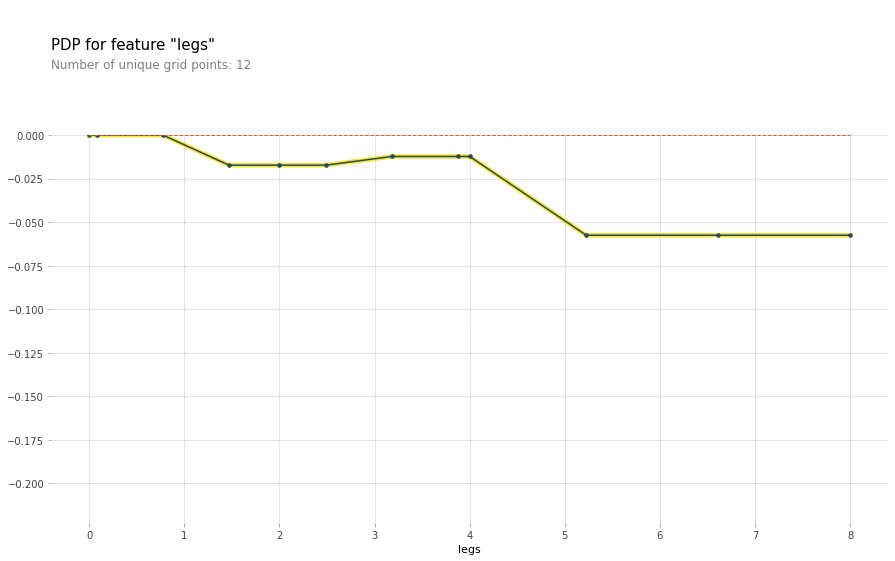

In [ ]:
# Creating a partial dependence plot

plt.rcParams['figure.dpi'] = 72

feature = 'legs'

isolated = pdp_isolate(
    model = model_four, 
    dataset = X_val_masked, 
    model_features = X_val_masked.columns, 
    feature = feature, 
    num_grid_points = 50
)

pdp_plot(isolated, feature_name=feature, plot_lines=True, frac_to_plot=0.01)

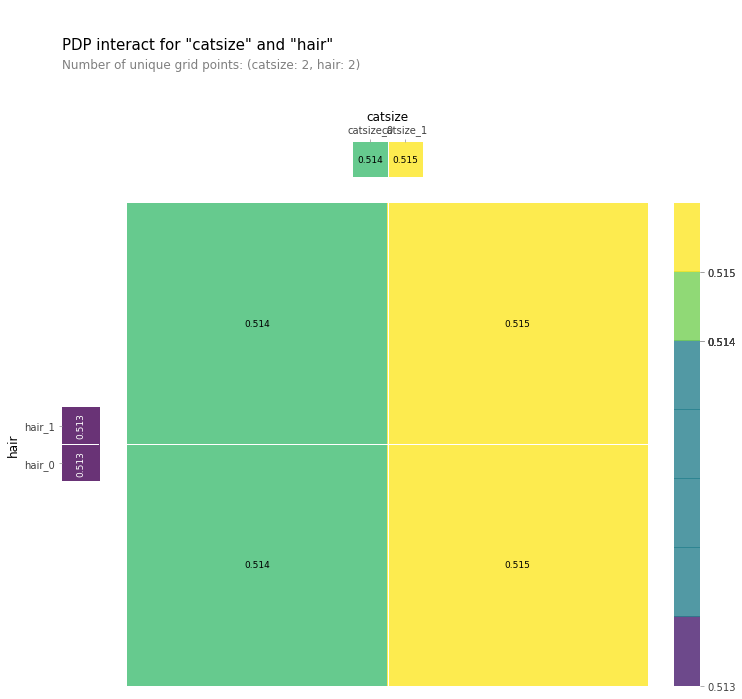

In [ ]:
# Partial dependence plot with 2 features and plot_type grid

features = ['catsize', 'hair']

interaction = pdp_interact(
    model = model_four, 
    dataset = X_val_masked, 
    model_features = X_val_masked.columns, 
    features = features
)

pdp_interact_plot(interaction, feature_names=features, plot_type='grid', plot_pdp=True);

In [ ]:
# Making a new model to work with the shapley plot

pipeline = make_pipeline(
    FunctionTransformer(wrangle, validate = False),
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='most_frequent')
)

X_train_processed = pipeline.fit_transform(X_train)
X_val_processed = pipeline.transform(X_val)

eval_set = [(X_train_processed, y_train), (X_val_processed, y_val)]

model_five = XGBClassifier(n_estimators=15, n_jobs=-1)
model_five.fit(X_train_processed, y_train, eval_set = eval_set, eval_metric = 'auc', early_stopping_rounds = 10)

[0]	validation_0-auc:0.763545	validation_1-auc:0.8
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.779412	validation_1-auc:0.776923
[2]	validation_0-auc:0.77709	validation_1-auc:0.776923
[3]	validation_0-auc:0.77709	validation_1-auc:0.776923
[4]	validation_0-auc:0.77709	validation_1-auc:0.776923
[5]	validation_0-auc:0.77709	validation_1-auc:0.776923
[6]	validation_0-auc:0.77709	validation_1-auc:0.776923
[7]	validation_0-auc:0.782121	validation_1-auc:0.769231
[8]	validation_0-auc:0.789474	validation_1-auc:0.769231
[9]	validation_0-auc:0.789474	validation_1-auc:0.769231
[10]	validation_0-auc:0.789474	validation_1-auc:0.769231
Stopping. Best iteration:
[0]	validation_0-auc:0.763545	validation_1-auc:0.8



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=15, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
# Selecting an individual row to explain

row = X_test.iloc[[0]]

In [ ]:
# Shap plot for the selected row

import shap

explainer = shap.TreeExplainer(model_five)
row_processed = pipeline.transform(row)
shap_values = explainer.shap_values(row_processed)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values, 
    features=row_processed, 
    link='logit' # For classification, this shows predicted probabilities
)

In [ ]:
# My best model is model_one. That's the RandomForestClassifier model.
# I'll do my test accuracy on that one

print('Test accuracy:', model_one.score(X_test, y_test))

Test accuracy: 0.7
